In [50]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit.classical import expr   # allows classical logic on mid circuit measurement
def get_ghz_circ_dynamic(num_qubit):   
    if num_qubit%2==1:                                                  # For odd number of qubits
        qr=QuantumRegister(num_qubit)
        num_mid_measurements=int(num_qubit/2)
        cr1=ClassicalRegister(num_mid_measurements,name="cr1")          # mid circuit measurement
        cr2=ClassicalRegister(num_qubit,name="cr2")                     # final measurement
        qc=QuantumCircuit(qr,cr1,cr2)
        for i in range(num_mid_measurements+1):
            qc.h(2*i)
        qc.barrier()
        for i in range(num_mid_measurements):
            qc.cx(2*i+2,2*i+1)
            qc.cx(2*i,2*i+1)
        qc.barrier()
        for i in range(num_mid_measurements):
            qc.measure(2*i+1,cr1[i])
            if i==0:
                parity=expr.lift(cr1[i])
            else :
                parity=expr.bit_xor(cr1[i],parity)
            with qc.if_test(parity):
                    qc.x(2*i+2)
    
        for i in range(num_mid_measurements):
            parity=expr.lift(cr1[i])
            with qc.if_test(parity):
                qc.x(2*i+1)
            qc.cx(2*i,2*i+1)

    else:                                                               # For even number of Qubits
        qr=QuantumRegister(num_qubit)
        num_mid_measurements=int((num_qubit-1)/2)
        cr1=ClassicalRegister(num_mid_measurements,name="cr1")          # mid circuit measurement
        cr2=ClassicalRegister(num_qubit,name="cr2")                     # final measurement
        qc=QuantumCircuit(qr,cr1,cr2)
        for i in range(num_mid_measurements+1):
            qc.h(2*i)
        
        for i in range(num_mid_measurements):
            qc.cx(2*i+2,2*i+1)
            qc.cx(2*i,2*i+1)
        
        for i in range(num_mid_measurements):
            qc.measure(2*i+1,cr1[i])
            if i==0:
                parity=expr.lift(cr1[i])
            else :
                parity=expr.bit_xor(cr1[i],parity)
            with qc.if_test(parity):
                    qc.x(2*i+2)
    
        for i in range(num_mid_measurements):
            parity=expr.lift(cr1[i])
            with qc.if_test(parity):
                qc.x(2*i+1)
            qc.cx(2*i,2*i+1)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc


In [51]:
def get_ghz_circ_static(num_qubit):
    if num_qubit%2==1:                                                     #odd no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-1)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-1):
            qc.cx(i,i+1)
            qc.cx(num_qubit-i-1,num_qubit-i-2)
        for i in range(num_qubit):
            qc.measure(qr[i],cr2[i])
        

    else:                                                                    #even no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-2)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-2):
            qc.cx(i,i+1)
            qc.cx(num_qubit-1-i-1,num_qubit-i-3)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc
    
    

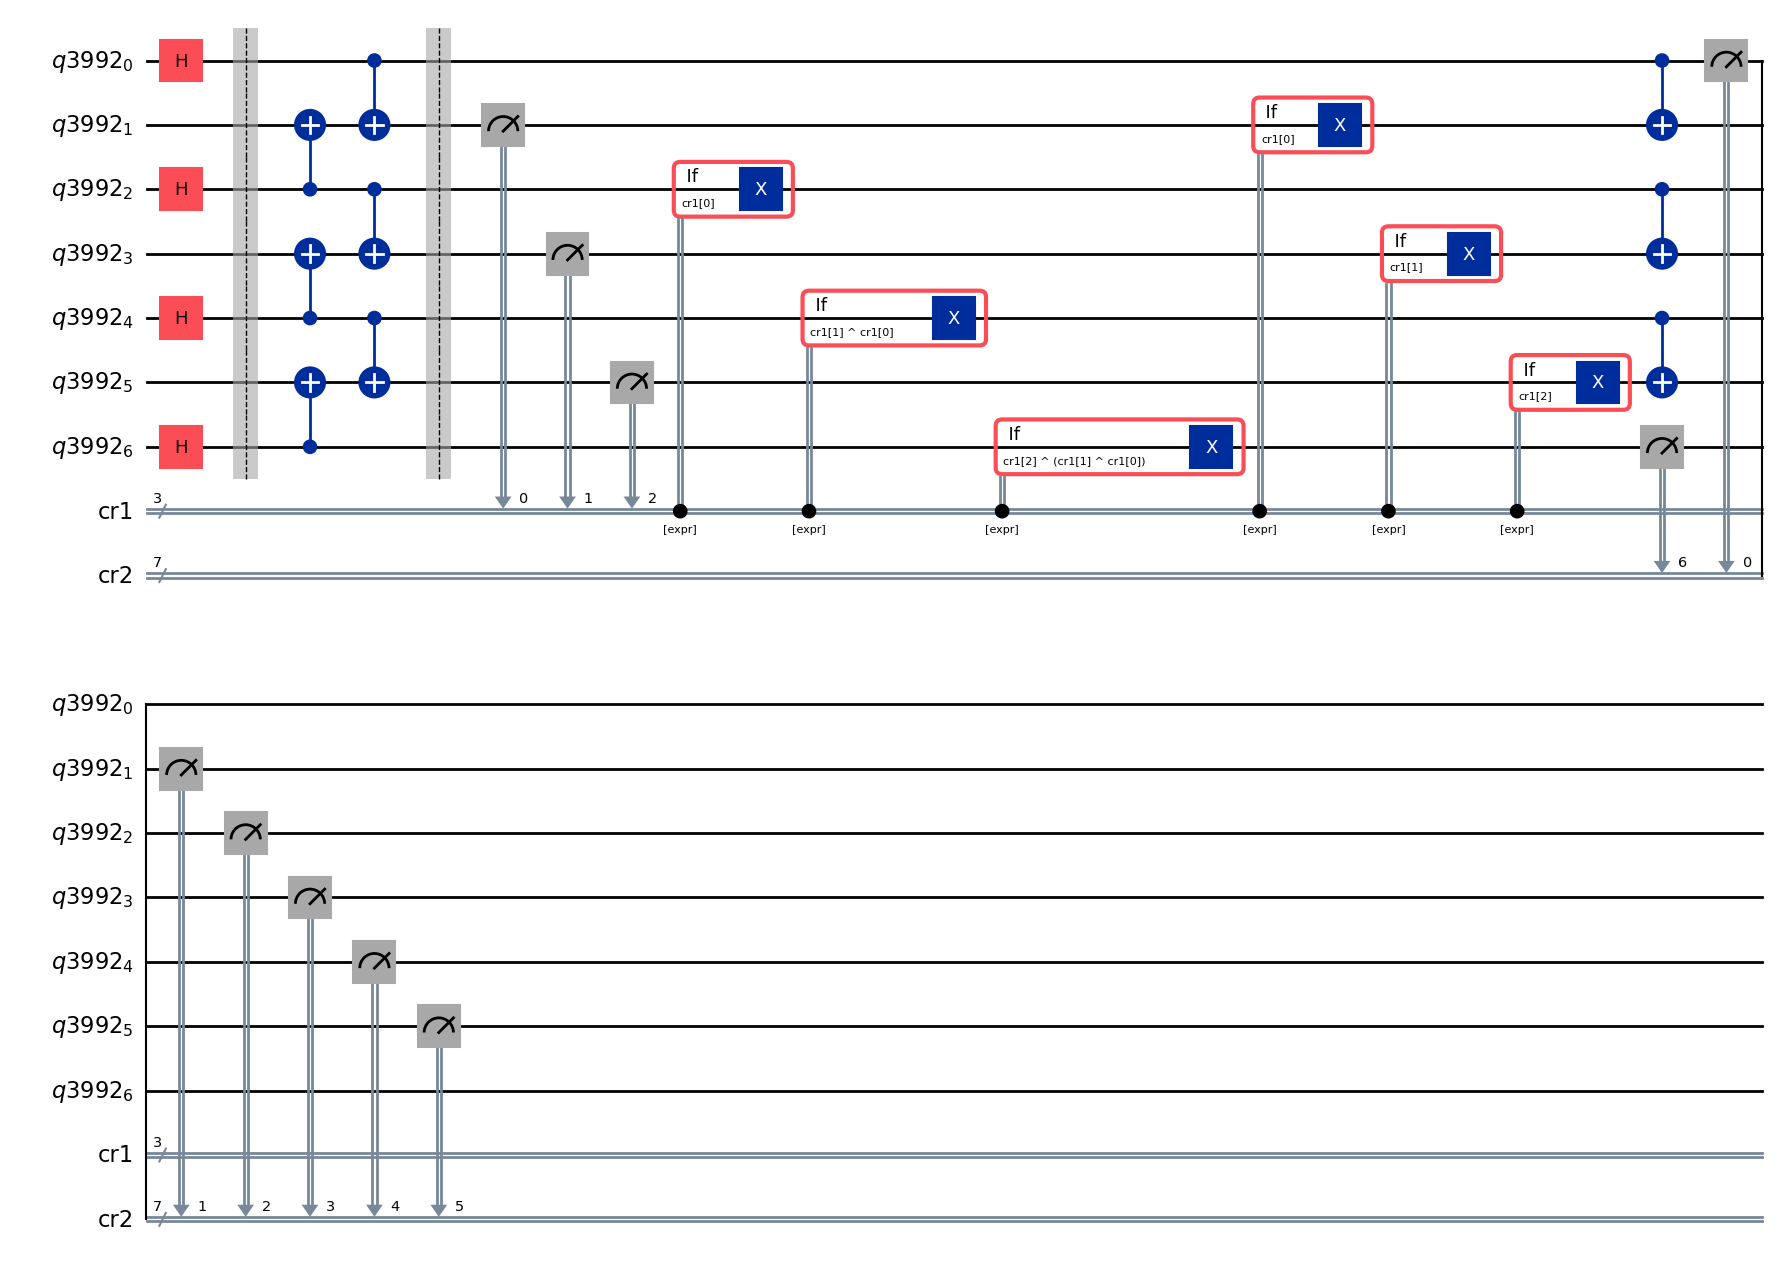

In [52]:
qc = get_ghz_circ_dynamic(num_qubit=7)
qc.draw("mpl")

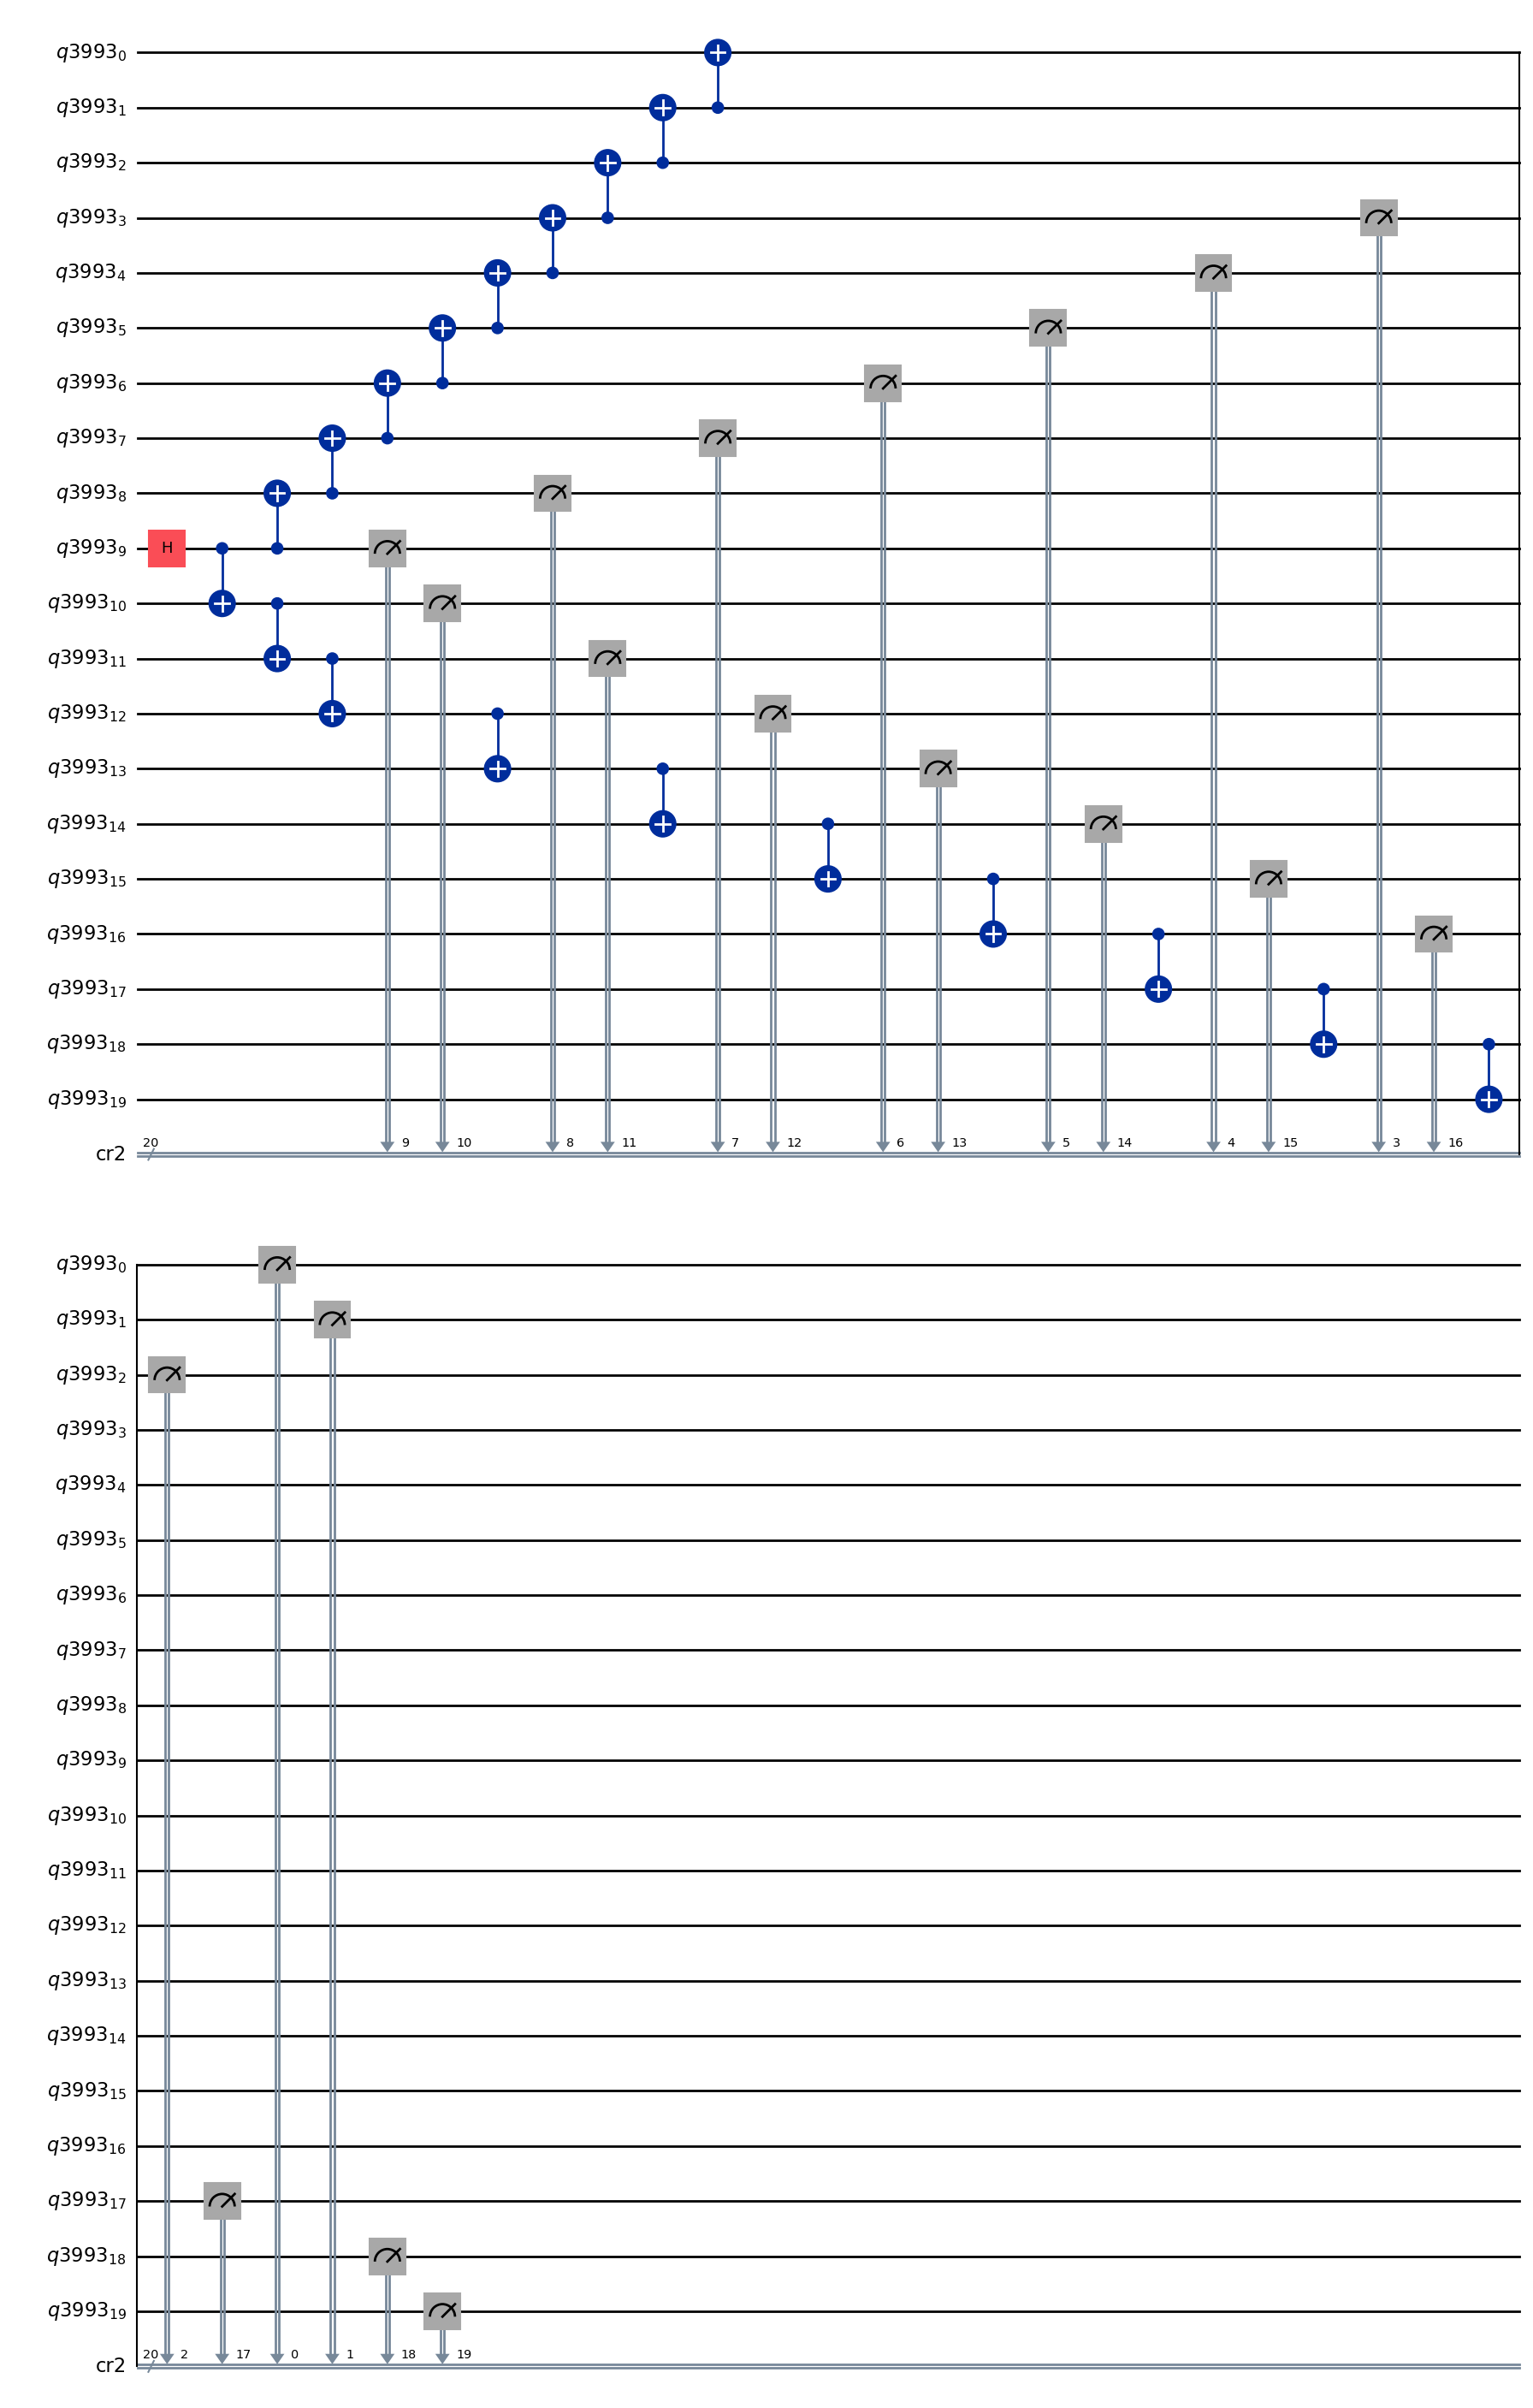

In [53]:
qc = get_ghz_circ_static(num_qubit=20)
qc.draw("mpl")

In [54]:
#Creating list of circuits [Static1, Dynamic1, Static1, Dyanmic1,...,static2,dynamic2,staic2,dynamic2,...] i.e. some copies of each of them
min_qubit=3
max_num_qubit=8
copies=3
#qc_list_dynamic=[]
#qc_list_static=[]
#observables=[]
qc_list=[]
num_qubit_list=list(range(min_qubit,max_num_qubit+1))
for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_ghz_circ_static(num_qubit))
        qc_list.append(get_ghz_circ_dynamic(num_qubit))

In [55]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
qc_transpiled_list=[]



qc_transpiled_list_ideal = pm.run(qc_list)



In [56]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [57]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_ideal[(i*copies)+(2*j)].data
        data_dynamic = result_ideal[(i*copies)+((2*j)+1)].data
        counts_static=data_static.cr2.get_counts()
        counts_dynamic=data_dynamic.cr2.get_counts()
        counts_list_ideal.append(counts_static)
        counts_list_ideal.append(counts_dynamic)

In [58]:
#genericBackendV2
# trasnpilation
# Creating list of transpiled circuits having 1 no of resets to 10 no of resets (10 copies of each circuit)
from qiskit.providers.fake_provider import GenericBackendV2
backend = GenericBackendV2(num_qubits=max_num_qubit,control_flow=True,seed=13)     # fixed seed for reproducibility, num_qubits at least should be 2

qc_transpiled_list_GenBackendV2 = transpile(qc_list, backend)


In [59]:
# Run the transpiled circuits using the simulated backend and post pocessing
job = backend.run(qc_transpiled_list_GenBackendV2)
result_GenBackendV2=job.result()


In [60]:
#get list counts_list_GenBackendV2 (argument required for Fidelity)
counts_list_GenBackendV2=result_GenBackendV2.get_counts()



In [61]:
print(counts_list_GenBackendV2)

[{'111': 494, '000': 509, '100': 6, '101': 6, '110': 4, '001': 2, '010': 2, '011': 1}, {'111 0': 247, '101 0': 2, '000 1': 236, '011 0': 6, '111 1': 273, '000 0': 251, '010 0': 1, '011 1': 1, '100 0': 4, '001 1': 1, '100 1': 1, '110 0': 1}, {'111': 527, '000': 480, '110': 2, '001': 4, '010': 1, '100': 5, '011': 3, '101': 2}, {'111 0': 258, '100 1': 4, '000 1': 258, '100 0': 4, '000 0': 242, '011 0': 2, '111 1': 242, '110 0': 2, '010 0': 2, '101 0': 2, '011 1': 2, '001 1': 1, '010 1': 1, '110 1': 3, '101 1': 1}, {'000': 484, '111': 516, '100': 5, '011': 7, '001': 3, '110': 5, '101': 2, '010': 2}, {'111 0': 251, '011 0': 3, '111 1': 240, '100 0': 4, '000 0': 242, '100 1': 6, '000 1': 268, '110 0': 4, '010 1': 1, '001 0': 2, '110 1': 2, '011 1': 1}, {'1000': 4, '0000': 515, '1111': 485, '0010': 2, '1011': 5, '1101': 2, '1110': 3, '0111': 2, '1100': 1, '0011': 4, '0001': 1}, {'1000 0': 1, '0000 1': 259, '1011 0': 2, '1111 1': 233, '1100 1': 3, '0000 0': 244, '0010 0': 2, '1111 0': 265, '00

In [62]:
#Calculation of lists of Fidelity mean and std deviation of all 4 hardware simulation
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
# For GHZ state analysis: index 0 of these lists store informationn of GHZ state having 3 qubits, index 1 for 4 qubits and so on 
Fidelity_mean_static_GenBackendV2=[]
Fidelity_mean_dynamic_GenBackendV2=[]
Fidelity_std_static_GenBackendV2=[]
Fidelity_std_dynamic_GenBackendV2=[]
Fidelity_copies_static_GenBackendV2=[]                  # last these 2 lists are required for intermediate steps
Fidelity_copies_dynamic_GenBackendV2=[]



for i in range(len(num_qubit_list)):
    
    for j in range(copies):
        
        Fidelity_static= hellinger_fidelity(counts_list_ideal[(i*copies)+(2*j)], counts_list_GenBackendV2[(i*copies)+(2*j)])
        Fidelity_dynamic=hellinger_fidelity(counts_list_ideal[(i*copies)+((2*j)+1)], counts_list_GenBackendV2[(i*copies)+((2*j)+1)])
        Fidelity_copies_static_GenBackendV2.append(Fidelity_static)
        Fidelity_copies_dynamic_GenBackendV2.append(Fidelity_dynamic)

    

    
    Fidelity_mean_static_GenBackendV2.append(statistics.mean(Fidelity_copies_static_GenBackendV2))
    Fidelity_mean_dynamic_GenBackendV2.append(statistics.mean(Fidelity_copies_dynamic_GenBackendV2))
    Fidelity_std_static_GenBackendV2.append(statistics.stdev(Fidelity_copies_static_GenBackendV2))
    Fidelity_std_dynamic_GenBackendV2.append(statistics.stdev(Fidelity_copies_dynamic_GenBackendV2))
    Fidelity_copies_static_GenBackendV2.clear()
    Fidelity_copies_dynamic_GenBackendV2.clear()

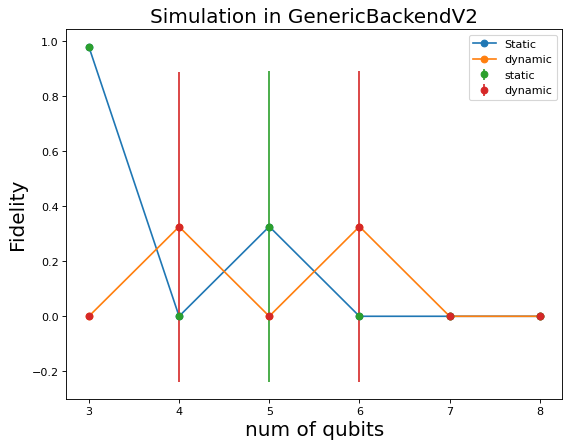

In [63]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
figure(figsize=(8,6), dpi=80)

plt.xlabel('num of qubits',fontsize=18)
plt.ylabel('Fidelity',fontsize=18)
plt.title('Simulation in GenericBackendV2',fontsize=18)
x = num_qubit_list
y_static = Fidelity_mean_static_GenBackendV2
y_dynamic = Fidelity_mean_dynamic_GenBackendV2
y_error_static =Fidelity_std_static_GenBackendV2
y_error_dynamic =Fidelity_std_dynamic_GenBackendV2
plt.plot(x, y_static, 'o-',label='Static')
plt.plot(x, y_dynamic, 'o-',label='dynamic')
plt.errorbar(x, y_static,
			yerr = y_error_static, label='static',
			fmt ='o')
plt.errorbar(x, y_dynamic,
			yerr = y_error_dynamic, label='dynamic',
			fmt ='o')

plt.legend()
plt.show()